# Linear regression model to predict the spot price of gold from real interest rates

Prices for gold and copper are sourced from a data provider's API using my own custom module; real yields, measured as the daily yield on TIPS, are reported by the Treasury Department

---

- Import libraries

In [1]:
import os, sys
import pandas as pd
import numpy as np
import scipy as stats
from dotenv import load_dotenv

from sklearn import model_selection as ms
from sklearn import linear_model as lm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline

*Load .env file, which has paths to data sources that I prefer to keep secret*

In [2]:
load_dotenv()

True

In [3]:
sys.path.insert(1, os.environ.get('PRICE_API'))
import finmod_apis

Importing API keys from local directory; this will break if not prescribed


---

In [4]:
#globally setting font sizes
params = {'axes.labelsize' : 16,
          'axes.titlesize' : 16, 
          'xtick.labelsize' : 16, 
          'ytick.labelsize' : 16, 
          'legend.fontsize': 16}
plt.rcParams.update(params)

---

### Table of Contents

1. [Objective/thesis of study](#objective)
1. [Import and explore the dataset](#get_data)
1. [Split/normalize the data](#split)
1. [Train the model](#train)
1. [Predict and evaluate](#predict)

---

<a id='objective'></a>
#### Objective of the study

- Predict the price of gold given real interest rates

- We’re using a simple linear regression model to predict the daily spot price of gold (y) based on the yield for 10-year TIPS (X).

---

<a id='get_data'></a>
#### Get and explore data; analysis and visualization

- Get and format data

In [5]:
gold_prices = finmod_apis.daily_price_data('ZGUSD', n_days=2530)

In [6]:
copper_prices = finmod_apis.daily_price_data('HGUSD', n_days=2530)

In [7]:
gold_prices[0]

{'date': '2021-11-05',
 'open': 1792.599976,
 'high': 1820.099976,
 'low': 1785.300049,
 'close': 1820.0,
 'adjClose': 1820.0,
 'volume': 276580.0,
 'unadjustedVolume': 276580.0,
 'change': 27.40002,
 'changePercent': 1.529,
 'vwap': 1808.46668,
 'label': 'November 05, 21',
 'changeOverTime': 0.01529}

In [8]:
def format_prices(json):
    df = pd.json_normalize(json)
    df.index = pd.to_datetime(df['date'])
    return df['adjClose']

In [9]:
gold_price = format_prices(gold_prices)

In [10]:
copper_price = format_prices(copper_prices)

---

*I have real yields stored elsewhere in pkl file... no sense recreating the wheel*

In [11]:
yields = pd.read_pickle(os.environ.get('TSY_SOURCE') + 'USTsy_real_yields.pkl')['10YR TIPS'].div(100)

---

In [12]:
df = pd.concat([gold_price, 
                yields, 
                copper_price], axis=1, keys=['Gold price',
                                             'Real 10yr yield', 
                                             'Copper price']).dropna()

In [13]:
df.shape

(2407, 3)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2407 entries, 2012-02-17 to 2021-10-29
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gold price       2407 non-null   float64
 1   Real 10yr yield  2407 non-null   float64
 2   Copper price     2407 non-null   float64
dtypes: float64(3)
memory usage: 75.2 KB


---

<AxesSubplot:>

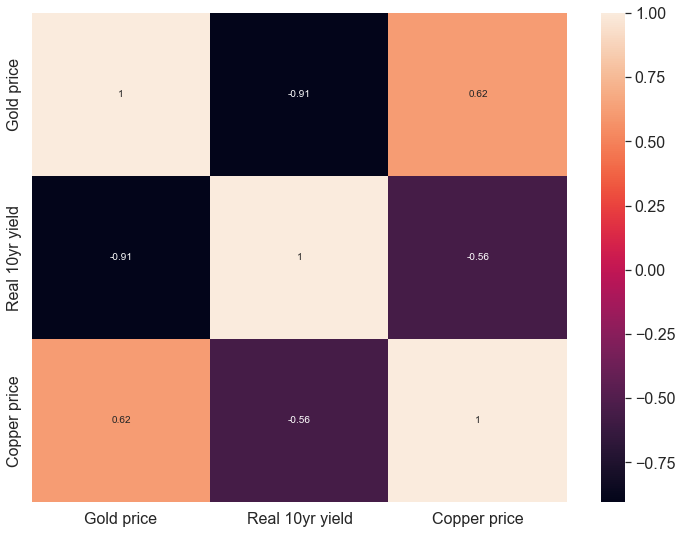

In [15]:
plt.figure(figsize=(12,9))
sns.heatmap(df.corr(), annot=True)

- Rolling correlation of gold and real yields

In [16]:
days = 50
rolling_correl = df.rolling(days).corr().unstack()[('Real 10yr yield', 'Gold price')][days:]

In [17]:
rolling_correl.tail(10)

2021-10-18   -0.542980
2021-10-19   -0.559173
2021-10-20   -0.611619
2021-10-21   -0.673178
2021-10-22   -0.720031
2021-10-25   -0.767293
2021-10-26   -0.789386
2021-10-27   -0.799814
2021-10-28   -0.807514
2021-10-29   -0.815157
Name: (Real 10yr yield, Gold price), dtype: float64

---

- Function for plotting descriptive statistics on a given series

In [18]:
def plot_descriptive_stats(series, series_name, sf=0.05, tail=2):
    '''
    plots series & confidence interval, and returns dict of
    descriptive statistics
    '''
    #put descriptive stats in dict that's returned
    #-----------------------------------------------
    mean = series.mean()
    stdev = series.std()
    z_score = stats.stats.norm.isf(np.divide(sf, tail))
    ub = np.add(mean, np.multiply(z_score, stdev))
    lb = np.subtract(mean, np.multiply(z_score, stdev))
    
    key_names = "Name Mean StDev Critical-value Tails Z-score CI-upper CI-lower".split()
    value_items = [series_name, mean, stdev, sf, tail, z_score, ub, lb]
    series_stats = {
        name: value for name, value in zip(key_names, value_items)
    }
    
    #build df & plot series with confidence interval
    #-----------------------------------------------
    df = pd.DataFrame({
        series_name: series,
        'Mean': np.zeros(len(series)) + mean,
        'CI, upper': np.zeros(len(series)) + ub,
        'CI, lower': np.zeros(len(series)) + lb,
    })
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    colors = ['r'] + ('gray ' * 3).split()
    styles = ['-', '--', '-', '-']
    
    #ignore lower ci if tail=1
    if tail == 1:
        df = df.drop('CI, lower', axis=1)
        colors = colors[:-1]
        styles = styles[:-1]
    
    for col, color, style, in zip(df.columns, colors, styles):
        ax.plot(df[col], 
                label=col,
                color=color, 
                ls=style)
    ax.legend(loc='best')
    ax.autoscale(axis='x', tight=True)
    ax.grid()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #center xtick marks
    for label in ax.xaxis.get_ticklabels():
        label.set_horizontalalignment('center')
        label.set_rotation(90)

    #show every n xtick if length of series is >1
    size_xaxis = len(series) // 20 if np.divide(len(series), 20) > 1. else 1
    plt.xticks([series.index[n] for n in range(0, len(series.index), size_xaxis)])
    
    return series_stats   

50-day rolling correlation between real interest rates and gold prices


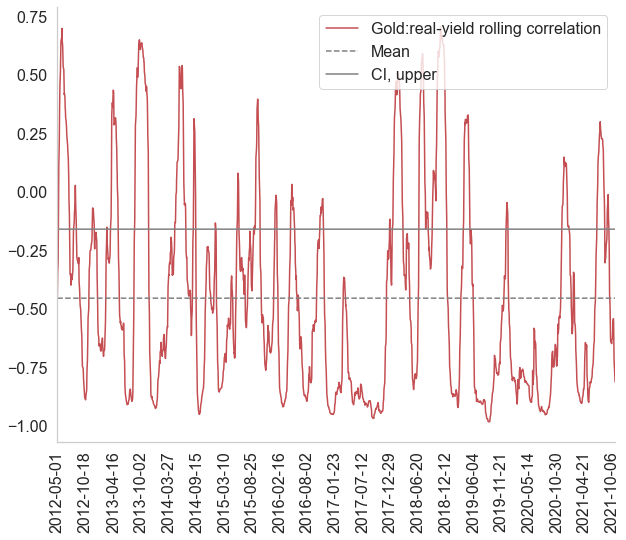

In [19]:
correl_stats = plot_descriptive_stats(rolling_correl, 'Gold:real-yield rolling correlation', sf=0.25, tail=1
)
print("{}-day rolling correlation between real interest rates and gold prices".format(days))

In [20]:
correl_stats

{'Name': 'Gold:real-yield rolling correlation',
 'Mean': -0.4554260283943972,
 'StDev': 0.4378984181496267,
 'Critical-value': 0.25,
 'Tails': 1,
 'Z-score': 0.6744897501960817,
 'CI-upper': -0.16006803372539619,
 'CI-lower': -0.7507840230633982}

- Copper to gold ratio

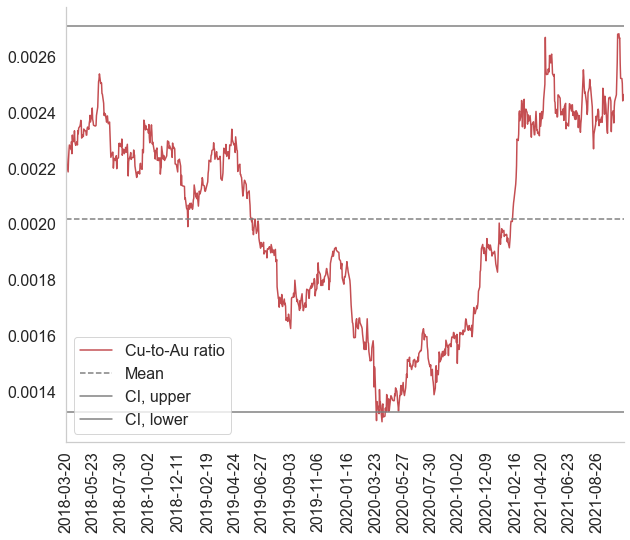

In [21]:
cu_au_stats = plot_descriptive_stats(
    np.divide(df['Copper price'], df['Gold price'])[-900:], 'Cu-to-Au ratio', sf=0.05, tail=2
)

In [22]:
cu_au_stats

{'Name': 'Cu-to-Au ratio',
 'Mean': 0.0020170945261406494,
 'StDev': 0.00035185302159856463,
 'Critical-value': 0.05,
 'Tails': 2,
 'Z-score': 1.9599639845400545,
 'CI-upper': 0.00270671377632543,
 'CI-lower': 0.0013274752759558687}

---

<a id='split'></a>
#### Normalize, split, and train model

We use the Train set to make the algorithm learn the data’s behavior and then we check the accuracy of our model on the Test set.
1. Features(X): the columns that are inserted into our model will be used to make predictions; these **must be 2darrays.**
1. Prediction(y): target variable that will be predicted by the features; these **must be 1darrays.**

In [23]:
x = df[["Real 10yr yield"]].fillna(method='ffill').to_numpy() #2d array
y = df["Gold price"].fillna(method='ffill').to_numpy() #1d array

In [24]:
x_train, x_test, y_train, y_test = ms.train_test_split(
    x, y, test_size=0.33, random_state=0
)

---

<a id='train'></a>
#### Train model

In [25]:
reg = lm.LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [26]:
print("Model intercept:")
display(reg.intercept_)

print("\nModel coefficients:")
display(reg.coef_)

print("\nModel fit on training data:")
display(reg.score(x_train, y_train))

Model intercept:


1456.0117512541433


Model coefficients:


array([-35898.54090456])


Model fit on training data:


0.8216221831067746

---

<a id='predict'></a>
#### Predict model

In [27]:
y_predict = reg.predict(x_train)

In [28]:
y_predict[:5]

array([1211.9016731 , 1542.16824943, 1301.64802536, 1298.05817127,
       1186.77269447])

- Compare actual vs predicted y values

,Feature X:,Actual Y,Predicted Y,error
1607,0.0025,1228.699951,1366.265399,-137.565448
1608,0.0080,1318.099976,1168.823424,149.276552
1609,0.0012,1197.300049,1412.933502,-215.633453
1610,0.0039,1163.300049,1316.007442,-152.707393
1611,0.0107,1226.500000,1071.897364,154.602636



Sum of squared errors: 15862775.984716585
Sum of the errors should equal zero: 0.0


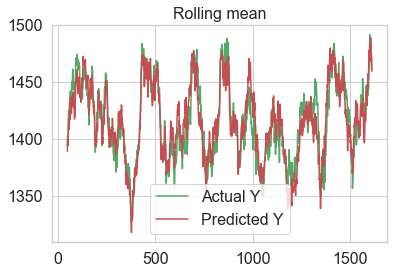

In [29]:
compared = pd.DataFrame(
    {'Feature X:': x_train.reshape(len(x_train)), 
     'Actual Y': y_train, 
     'Predicted Y': y_predict, 
     'error': np.subtract(y_train, y_predict)},
)
display(compared.tail())
compared[["Actual Y", "Predicted Y"]].rolling(50).mean().plot(title="Rolling mean", color=['g','r'])

print('\nSum of squared errors:', np.sum(np.square(compared['error'])))
print('Sum of the errors should equal zero:', compared['error'].sum().round(5))

---